<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca?subject=Day 13: Segmentation Evaluation Lecture"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 13, February 25, 2019</h4>

#### Introduction

Thus far, we have seen a few segmentation algorithms and visualizaed the results as an image. By overlapping the segmentation results onto the original image, we can **qualitatively** judge whether one segmentation algorithms works better than the other. In order to determine **quantatively** whether a segmentation algorithm works well, we need to establish an *error* metric and a known reference data.

In this Jupyter Notebook, we will example a few metrics for measuring segmentation similarity and how to perform these evaluation using SimpleITK.

In [1]:
import SimpleITK as sitk

import numpy as np

%run update_path_to_download_script
from downloaddata import fetch_data as fdata
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact, fixed
from myshow import myshow, myshow3d

Suppose you have two binary images as results of segmentation.  Let **Source**, or $S$, be the output binary image from a segmentation algorithm, and **Target**, or $T$, be another binary image of which we are going to use as a reference. $T$ can be the output of another segmentation algorithm, or it can be the result of manual segmentation perform by experts.

Below is an MRI image using the [FLAIR](https://en.wikipedia.org/wiki/Fluid-attenuated_inversion_recovery) (Fluid-attenuated inversion recovery) sequence. By carefully choosing the inversion time, the signal from any particular tissue can be nulled. For example, FLAIR can be used in brain image to suppress [cerebospinal fluid](https://en.wikipedia.org/wiki/Cerebrospinal_fluid) (CSF) effect on the image, so as to bring out the periventricular hyperintense lesion.

<img src="1-s2.0-S0720048X13002830-gr3_lrg.jpg" width="850"/>

Image courtesy of the following [paper](https://www.sciencedirect.com/science/article/pii/S0720048X13002830):

FLAIR lesion segmentation: Application in patients with brain tumors and acute ischemic stroke,
*Artzi et al.*, **European Journal of Radiology**, 82(9) pp.1512-1518, 2013



Often, a **ground truth** needs to be established. In medical imaging, this is typically achieved by having an expert (i.e. a radiologist) to *manually* segment (delineate) the region of interest. Obviously, this is a very intensive manual work. Alternatively, the output of a well-known algorithm can be used as a *bronze standard*, for which a new algorithm can be evaluated against.

<img src="Seg_Eval1.PNG" width="550"/>

While they may look similar, one can visualize the difference by overlay:

<img src="Seg_Eval2.PNG" width="550"/>

But what if we want to measure these difference **quantitatively**?  One may measure the following:

* Amount of overlapping,
* Distance between curves

These quantitative measurements are not only useful for determine the quality of segmentation, they are also useful to measure the quality of image registration, as we will see in the following week.

For medical image segmentation, no single evaluation metric provides a complete picture of the segmentation result. Instead, many evaluation metrics are often used in conjunctions. For example, consider the following two segmentations. The amount of overlapping is the same, but obviously two segmentation. Moreover, the shape of the contour is the same!

<img src="Seg_Eval3.PNG" width="550"/>

#### How is the reference segmentation generated?

In the medical domain, reference data is commonly obtained via manual segmentation by an expert, which is a long tedious and costly process. 

![manual segmentation](http://2nznub4x5d61ra4q12fyu67t-wpengine.netdna-ssl.com/img/5dfhgh.jpg)

*image curtesy of [wacom](https://www.wacom.com/en-sg/enterprise/business-solutions/industries/healthcare/medical-imaging)*

When the resource is limited, the reference data may be defined by a single expert. This less than ideal. when multiple experts provide you with their input then you can potentially combine them to obtain reference data that is closer to the ever elusive **ground truth**. In this notebook we show two approaches to combining input from multiple ovservers, majority vote and the Simultaneous Truth and Performance Level Estimation [(STAPLE)](http://crl.med.harvard.edu/publications/warfield-staple-tmi-press-2004.pdf).

When it comes to manual segmentation, there is always *inter-user* and *intra-user* variability.  Suppose we use a trivial example of reading off the air temperature from an analog thermometer: ![analog thermometer](https://www.weathershack.com/images/products/taylor/6712n-1d.jpg)

image curtesy of [weathershake](https://www.weathershack.com)

**Question**: What is the temperature? What is the ground truth?  How do we get an answer that is *good enough*?

#### Accuracy: Precision + trueness

There is a lot of confusion about what it means to be **accurate**: so much to a point there is actually an [ISO standard](https://www.iso.org/obp/ui/#iso:std:iso:5725:-1:ed-1:v1:en) for it.

<img src="Accuracy.PNG" width="550"/>

Take us take a survey about what the temperature is according to the analog theometer above.  There are $36$ students currently registered in class so we will get $36$ answers. Not all answers are identical, so we have a distribution. Suppose we take the *mean* and the *standard deviation* of all answers.

Suppose the theometer has more tick marks and the needle is narrow, so everyone is given a very similar answer. In this case, we have a narrow deviation: we have a precise answer.

However, having a precise answer doesn't mean we have a *true* answer. There could be something wrong with the theometer so that the temperature indicated by the needle is always a few degrees cooler (or warmer). In this case, we may want to get a different theometer and use it as a reference. The difference between the *mean* answer to the *reference value* is called the trueness.

In two dimension, suppose we are throwing darts. We may end up with the following distributions:


<img src="trueness_precision.PNG" width="850"/>

In any measurement science, the **ground truth** is almost always impossible to determine. Instead, through multiple measurements that are both precise and true, we can try to approximate the ground truth using the mean and the standard deviation.

Similarly, when multiple users perform manual segmentation multiple of times, we generally hope that:
* an expert user is more true than the novice
* an expert user is more precise than the novice

Once we have a reference, we can compare our algorithm's performance using multiple criteria, as usually there is no single evaluation measure (metric) that conveys all of the relevant information. In this notebook we illustrate the use of the following evaluation criteria:
* Overlap measures:
  * Jaccard and Dice coefficients
  * false negative and false positive errors
* Surface distance measures:
  * Hausdorff distance (symmetric)
  * mean, median, max and standard deviation between surfaces
* Volume measures:
  * volume similarity $\frac{2*(v1-v2)}{v1+v2}$
  
The relevant criteria are task depedent, so you need to ask yourself whether you are interested in detecting spurious errors not not (mean or max surface distance), whether over/under segmentation should be differentiated (volume similarity and Dice or just Dice), and what is the ratio between acceptable errors and the size of the segmented object (Dice coefficient may be too sensitive to small errors when the segmented object is small and not sensitive enough to large error when the segmented object is large).


The data we use in the notebook is a set of manually segmented liver tumors from a single clinical CT scan. A larger dataset (four scans) is freely available from this [MIDAS repository](http://www.insight-journal.org/midas/collection/view/38). The relevant publication is: T. Popa et al., "Tumor Volume Measurement and Volume Measurement Comparison Plug-ins for VolView Using ITK", SPIE Medical Imaging: Visualization, Image-Guided Procedures, and Display, 2006.

## Similarity metrics

Let us define several similarity metrics first.

But first, define some terminology for set series. Let **S** and **T** bet two sets of binary labels:


<img src="Venn_Diagram.png" width="550"/>

Then:
* Intersection: $S\bigcap T$
* Union: $S\bigcup T$
* Set difference of S and T: $ S \setminus T$
* Set difference of T and S: $ T \setminus S$

Note the order of operation. Set operation such as intersection and union are commutative:

$ S \bigcap T = T \bigcap S$ and

$ S \bigcup T = T \bigcup S$

but set difference is **not**

$S \setminus T \ne T \setminus S$

In the context of image segmentation, we denote S to be the source (segmentation we generated using an algorithm) and T to the target (a label that we assume to be good). Then it is easy to define the following:

* False Negative: $T \setminus S$,
* False Positive: $S \setminus T$, 
* True Positive: $S \bigcap T$,
* True Negative: $X - S \bigcup T$, where X is the entire set.

### Jaccard Similarity Coefficient

[Jaccard similarity coefficient](https://en.wikipedia.org/wiki/Jaccard_index), also known as **Intersection over Union**, is a statistical measure used for comparing the similarity and diversity of sample sets. In the general case, it is defined as:

$J(S,T) = \frac{| S \bigcap T |}{| S \bigcup T |} = \frac{| S \bigcap T |}{ | S | + | T | - | S | \bigcap | T |}$ 

It is easy to see that:

$J(S,T) = \frac{TP}{TP + FP + FN}$

In the context of image segmentation, Let **S** be the binary segmentation resulted from a segmentation algorithm, and **T** be a reference data of which the segmentation results is compared against to.  The **intersection**, $S \bigcap T$ is the overlapping area between these binary images. The **union**, $S \bigcup T$ is the (spatially) combined region.  The operator $| |$ denotes the area: it can be simply computed by counting the number of pixels.

If both S and T are empty, we define $J(S,T) = 1$.

**Question**: What is the range of $J$?

Previously, we have applied several segmentation algorithms to a common dataset. The example below loads a 2D CT image and applies both a connectedThreshold and confidenceConnected filters using the same seed.

Fetching cthead1.png


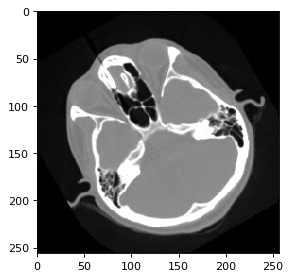

In [2]:
# load an image: CT of a head
img_ct = sitk.ReadImage(fdata("cthead1.png"))

# to visualize the labels image in RGB needs an image with 0-255 range
#
# we don't need to do this for THIS particular image (it is already rescaled).
img_255 = sitk.Cast(sitk.RescaleIntensity(img_ct), sitk.sitkUInt8)

myshow(img_ct)

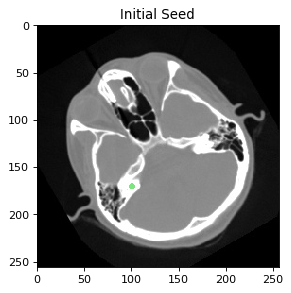

In [3]:
seed = (100, 170)
seg_connectedThreshold = sitk.Image(img_ct.GetSize(), sitk.sitkUInt8)
seg_connectedThreshold.CopyInformation(img_ct)
seg_connectedThreshold[seed] = 1
seg_connectedThreshold = sitk.BinaryDilate(seg_connectedThreshold, 3)
myshow(sitk.LabelOverlay(img_255, seg_connectedThreshold), "Initial Seed")

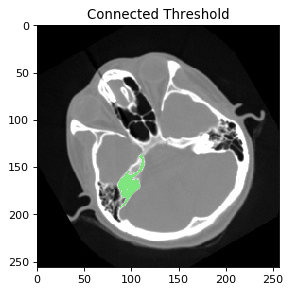

In [4]:
seg_connectedThreshold = sitk.ConnectedThreshold(img_ct, seedList=[seed], lower=230, upper=255)
myshow(sitk.LabelOverlay(img_255,seg_connectedThreshold), "Connected Threshold")

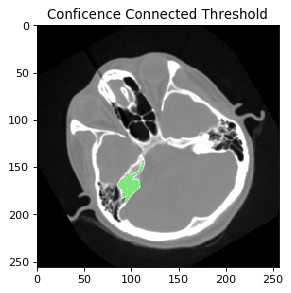

In [5]:
seg_confidenceConnected = sitk.ConfidenceConnected(img_ct, 
                                                   seedList=[seed], 
                                                   numberOfIterations = 10, 
                                                   multiplier = 2.5, 
                                                   initialNeighborhoodRadius = 3, 
                                                   replaceValue = 1)
myshow(sitk.LabelOverlay( img_255, seg_confidenceConnected), "Conficence Connected Threshold")

Now we have 2 segmentation results. They looks close, but how do we quantify the similarity/difference?

In [6]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute( seg_confidenceConnected, seg_connectedThreshold )
print( overlap_measures_filter.GetJaccardCoefficient() )

0.8203592814371258


In this simple example, we are using one of the segmentation result as the **reference**. This is because we don't have a ground truth segmentation.

**Question**: Does the order of label maps as input to sitk.LabelOverlapMeasuresImageFilter() when computing Jaccard Similarity Coefficient?  How do you check?

In [9]:
# enter your codes here

### Dice Similarity Cofficient

[Dice Similarit Cofficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) is another area based measure of similarity:

$DSC(S,T) = \frac{ 2 | S \bigcap T | }{ | S | + | T | }$

The Dice metris was initially intented to be a representation to the presence or absence of data. It is easy to see that:

$DSC = \frac{ 2 TP }{2TP + FP + FN}$

In fact, Dice metric is similar to Jaccard coefficient. Both are equivalent in the sense that, given one, the other can be computed:

$J = DSC/(2-DSC)$, and

$DSC = 2J/(1+J)$

**Question**: What is the range for Dice Similarity Cofficient?

In [ ]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute( seg_confidenceConnected, seg_connectedThreshold )
print( overlap_measures_filter.GetDiceCoefficient() )

In fact, they are monotonic to each other.  Jaccard coefficient is always larger than Dice metric except at the extrema $\{0,1\}$ where they are equal. Since we can convert one to the other, it means that both of the metrics measure the same aspects and provide the same system ranking. [Therefore, it does not provide additional information to use them together as validation metrices](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4533825/pdf/12880_2015_Article_68.pdf).

### Sensitivity and Specificity

While Dice metric (and by extension, Jaccard index) measures the amount of the overlapping between the segmentated result and what we assumed to be the good answer (**note**: I am still not using the word *ground truth*), it does not tell us anything about the *shape* or the edges of the segmented region compared to the good answer:

<img src="Dice_noneSpecific.png" width="550"/>

These are two clearly different segmentations but their Dice/Jaccard cofficients are the same.

We therefore needs other metrics in conjunction:

* True Positive Rate (TPR): 
  * $\frac{TP}{TP+FN}$ or 
  * $\frac{| S \bigcap T |}{ | T |}$
  * also called **Sensitivity** and **Recall**, measures the portion of positive voxels in the good answer that are also identified as positive by the segmentation being evaluated.
* True Negative Rate (TNR):
  * $\frac{TN}{TN+FP}$, or
  * *fill your answer here using the set theory*
  * also called **Specificity**, measures the portion of negative voxels (background) in the good answer segmentation that are also identified as negative by the segmentation algorithm being evaluated.

Collaterally, we can also define the following two metrics:
* False Positive Rate (FPR):
  * $\frac{FP}{FP+TN} = 1 - TNR$,
  * also called **Fallout**
* False Negative Rate (FNR):
  * $\frac{FN}{FN+TP} = 1-TPR$

Since FPR and FNR has inverse relation to TPR and TNR, respectively, only one of each two equivalent measure should be selected for validation and not both of them together: i.e. either FPR or TNR and analogously, either FNR or TPR.

In [10]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute( seg_confidenceConnected, seg_connectedThreshold )
print(overlap_measures_filter.GetFalseNegativeError())
print(overlap_measures_filter.GetFalsePositiveError())

0.17964071856287425
0.0


Take a look at the segmentation results from connectedThreshold filter and confidenceConnected filter. Discuss the result of GetFalsePositiveError(). **WHY**

**Question**: does the order of the input to sitk.LabelOverlapMeasuresImageFilter() matter now?

In [ ]:
## type in your codes here
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute( seg_connectedThreshold, seg_confidenceConnected  )
print(overlap_measures_filter.GetFalseNegativeError())
print(overlap_measures_filter.GetFalsePositiveError())

### Volume Similarity

The volume similarity coefficient, $VS$, is a measure of the similarity between the source and target volumes. Although this measure does not reflect segmentation (or registration, as we will see later in the course) accuracy (i.e. source and target regions can be disjoint and still have qual volumes), it is a conventional measure included for retrospective evaluation of prior studies. It is equal to the differences between two volumes (or areas in 2D) divided by their mean volume (area):

$VS = \frac{| S | - | T |}{| S | + | T |}$

(There are many definitions for VS: as an [example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4533825/pdf/12880_2015_Article_68.pdf). The definition we use is what is implemented in [ITK/SimpleITK](http://www.insight-journal.org/browse/publication/707)

In [ ]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
overlap_measures_filter.Execute( seg_confidenceConnected, seg_connectedThreshold )
print(overlap_measures_filter.GetVolumeSimilarity())

**Question**: What does negative VS mean?

**Question**: does the input order to sitk.LabelOverlapMeasuresImageFilter() matter for VS?

In [ ]:
## enter your codes to answer the above questions.

### Hausdorff Distance

Housdorff distance (HD) is a spatial distance based metric widely used in the evaluation of image segmentation as a *dissimilarity measure*. Used in conjunction to overlapping metrics, spatial distance based metrics are recommended when the segmentation overall accuracy, e.e. contour, of the segmentation is of importance.

Suppose we got two curves/contours

<img src="Hausdorff.png" width="550"/>

where $R_n$ is a point on the red curve and $G_n$ is a point on the green curve, respectively. Then the Hausdorff distance between the point sets $R$ and $G$ is defined by:

$HD(G,R) = max( h(G,R), h(R,G) )$

where $h(g,r)$ is called the *directed* Hausdorff distance and is given by:

$h(g,r) = \max_{g\in G} \min_{r \in R} \| g - r \|$

where $\| g - r \|$ is some distance norm (e.g. Euclidean distance).

In this particular example,

$HD(G,R) = \|G_4 - R_4 \|$.  **WHY**?

In [ ]:
## work it out by a simple enumeration.

**Question**: does $h(G,R)=h(R,G)$?

Hausdorff distance gives us another perspective to the **shape** of the segmentation. If two segmentations are similar in shape and in proximity, their HD will be small. Using the above example where one label is entirely inside the other, The Dice Coefficient will be the same but the Hausdorff distance will be different depending on the location of the label.

In [ ]:
hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
hausdorff_distance_filter.Execute(seg_confidenceConnected, seg_connectedThreshold)
print(hausdorff_distance_filter.GetHausdorffDistance())

**Question**: does the input order to  sitk.LabelOverlapMeasuresImageFilter matter for Hausdorff Distance?

**Question**: What is the unit here?

In [ ]:
## enter your code here: